# Introduction

The `hep_tables` package is for prototyping a hierarchical access language in python. It has elements of `numpy`'s slicing syntax and elements of LINQ from C# in it. And whatever else seems to work. Be warned that lots of stuff is hardwired - especially the surrounding code, the backend, etc.

This requires that you have a `servicex` instance running as a datasource on local ports 5000 and 9000.

In [ ]:
import sys
sys.path = ['..'] + sys.path
from hep_tables import xaod_table,make_local
from func_adl import EventDataset
import matplotlib.pyplot as plt

#import logging
#logging.basicConfig(level=logging.NOTSET)
#logging.getLogger("urllib3").setLevel(logging.WARNING)
#logging.getLogger("matplotlib").setLevel(logging.WARNING)

Everything has to start from a dataset.

In [ ]:
dataset = EventDataset('localds://mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')

And we need to frame this as a hierarchical `DataFrame`. This implies some knowledge of how to translate it into columns, so here we need indicate that this is a dataset with ATLAS `xAOD` files in it.

In [3]:
df = xaod_table(dataset)

# Simple `numpy` syntax

First, lets just get all the $p_T$'s of jets from a data sample. Note that in ATLAS units are in `MeV`, but `GeV` just makes more sense. So divide the jet pt's by 1000.

In [4]:
%%time
pts = df.Electrons("Electrons").pt/1000.0

Wall time: 0 ns


We just have the DAG for generating the pt's of all jets. Next we need to actually run the thing

In [5]:
%%time
np_pts = make_local(pts)

Wall time: 4min 5s


In [6]:
print (type(np_pts))
print (type(np_pts[b'col1']))
print (len(np_pts[b'col1']))
np_pts

<class 'dict'>
<class 'awkward.array.jagged.JaggedArray'>
1843800


{b'col1': <JaggedArray [[5.79458154296875] [36.92266796875 4.5147587890625 4.67144482421875 3.811003662109375] [] ... [36.46915625 25.50325 13.456806640625 ... 4.27271728515625 4.17789990234375 3.15295556640625] [43.63255859375 39.20566796875 3.786251953125] [39.07298828125 43.704296875 3.854654541015625 3.91102734375]] at 0x01a6b34792c8>}

i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


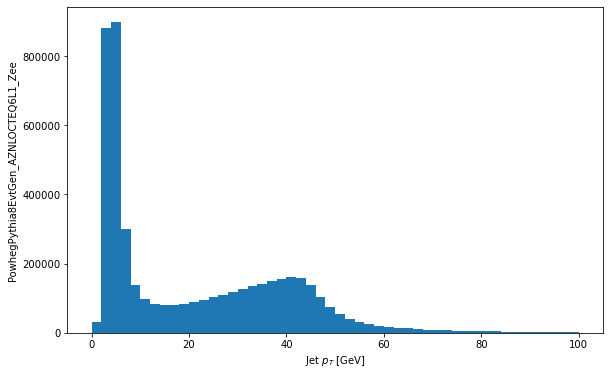

In [7]:
s = 6
plt.figure(figsize=(s*1.6,s))
plt.hist(np_pts[b'col1'].flatten(), range=(0, 100), bins=50)
plt.xlabel('Jet $p_T$ [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

## Filtering

What if we only want to look at the jets with a pT above 50 GeV? Then we use the slice operations that we've become use to.

In [8]:
%%time
pts_good = df.Electrons("Electrons").pt[df.Electrons("Electrons").pt > 50000.0]/1000.0
np_pts_good = make_local(pts_good)

Wall time: 3min 21s


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


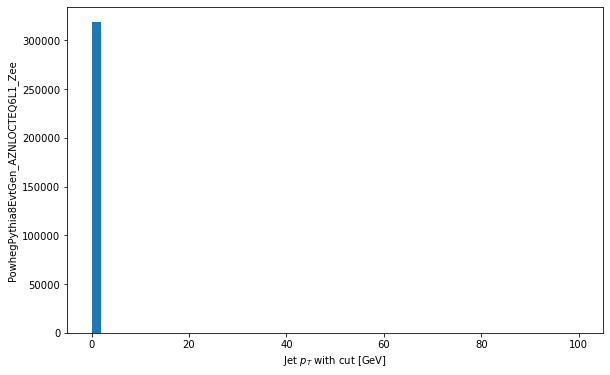

In [9]:
s = 6
plt.figure(figsize=(s*1.6,s))
plt.hist(np_pts_good[b'col1'].flatten(), range=(0, 100), bins=50)
plt.xlabel('Jet $p_T$ with cut [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

We can do this a little bit more in short hand:

In [10]:
%%time
eles = df.Electrons("Electrons")
pts_good_short = eles.pt[eles.pt > 50000.0]/1000.0
np_pts_good_short = make_local(pts_good)

Wall time: 3min 26s


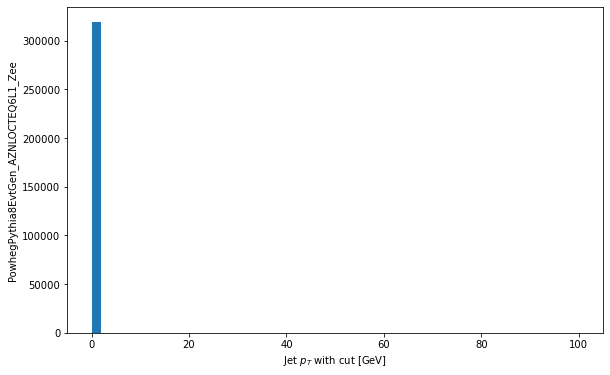

In [11]:
s = 6
plt.figure(figsize=(s*1.6,s))
plt.hist(np_pts_good_short[b'col1'].flatten(), range=(0, 100), bins=50)
plt.xlabel('Jet $p_T$ with cut [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

In the end, while this is interesting, probably, what we want to do, is look at all aspects of electrons after a pt cut. In that case, we need to cut on thet.

In [13]:
good_eles = eles[eles.pt > 50000.0]
pts_good_whole = good_eles.pt
np_pts_good_whole = make_local(pts_good_whole)

AssertionError: 

In [ ]:
s = 6
plt.figure(figsize=(s*1.6,s))
plt.hist(np_pts_good_whole[b'col1'].flatten(), range=(0, 100), bins=50)
plt.xlabel('Jet $p_T$ with cut [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

So now we can look at the $\eta$ distributions before and after that cut if we like.

In [ ]:
%%time
eta_all = eles.eta
eta_good = good_eles.eta

np_eta_all = make_local(eta_all)
np_eta_good = make_local(np_eta_good)